<a href="https://colab.research.google.com/github/H-y-hoon/2023_AI_SPARK_Challenge/blob/main/ensemble_final_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 참고링크

https://github.com/yzhao062/pyod

0 : normal

1 : abnormal

In [ ]:
!pip install pyod --q
!pip install suod --q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 34.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score
from pyod.models.ecod import ECOD
from pyod.models.auto_encoder_torch import AutoEncoder
from pyod.models.suod import SUOD
from pyod.models.lof import LOF
from pyod.models.copod import COPOD
from pyod.models.iforest import IForest

In [ ]:
train = pd.read_csv("/content/drive/MyDrive/PythonProjects/datafiles/AirPressure/train_data.csv")
test = pd.read_csv("/content/drive/MyDrive/PythonProjects/datafiles/AirPressure/test_data.csv")
submission = pd.read_csv("/content/drive/MyDrive/PythonProjects/datafiles/AirPressure/answer_sample.csv")

# 클러스터링

In [ ]:
train = train.iloc[:,:-1]
test = test.iloc[:,:-1]

In [ ]:
df = pd.concat([train,test], axis=0)
df

,air_inflow,air_end_temp,out_pressure,motor_current,motor_rpm,motor_temp,motor_vibe
0,1.59,41.00,0.7,20.53,1680.0,58.67,2.93
1,2.97,59.28,0.7,38.40,3142.0,74.91,3.75
2,1.91,45.29,0.7,24.73,2023.0,62.48,3.12
3,2.37,51.33,0.7,30.63,2506.0,67.84,3.39
4,1.90,45.21,0.7,24.65,2017.0,62.41,3.12
...,...,...,...,...,...,...,...
7384,2.12,48.08,0.7,27.45,2246.0,64.96,3.25
7385,1.48,39.63,0.7,19.19,1570.0,57.44,2.87
7386,1.56,40.61,0.7,20.15,1649.0,58.32,2.92
7387,1.59,40.99,0.7,20.52,1679.0,58.66,2.93


<function matplotlib.pyplot.show(close=None, block=None)>

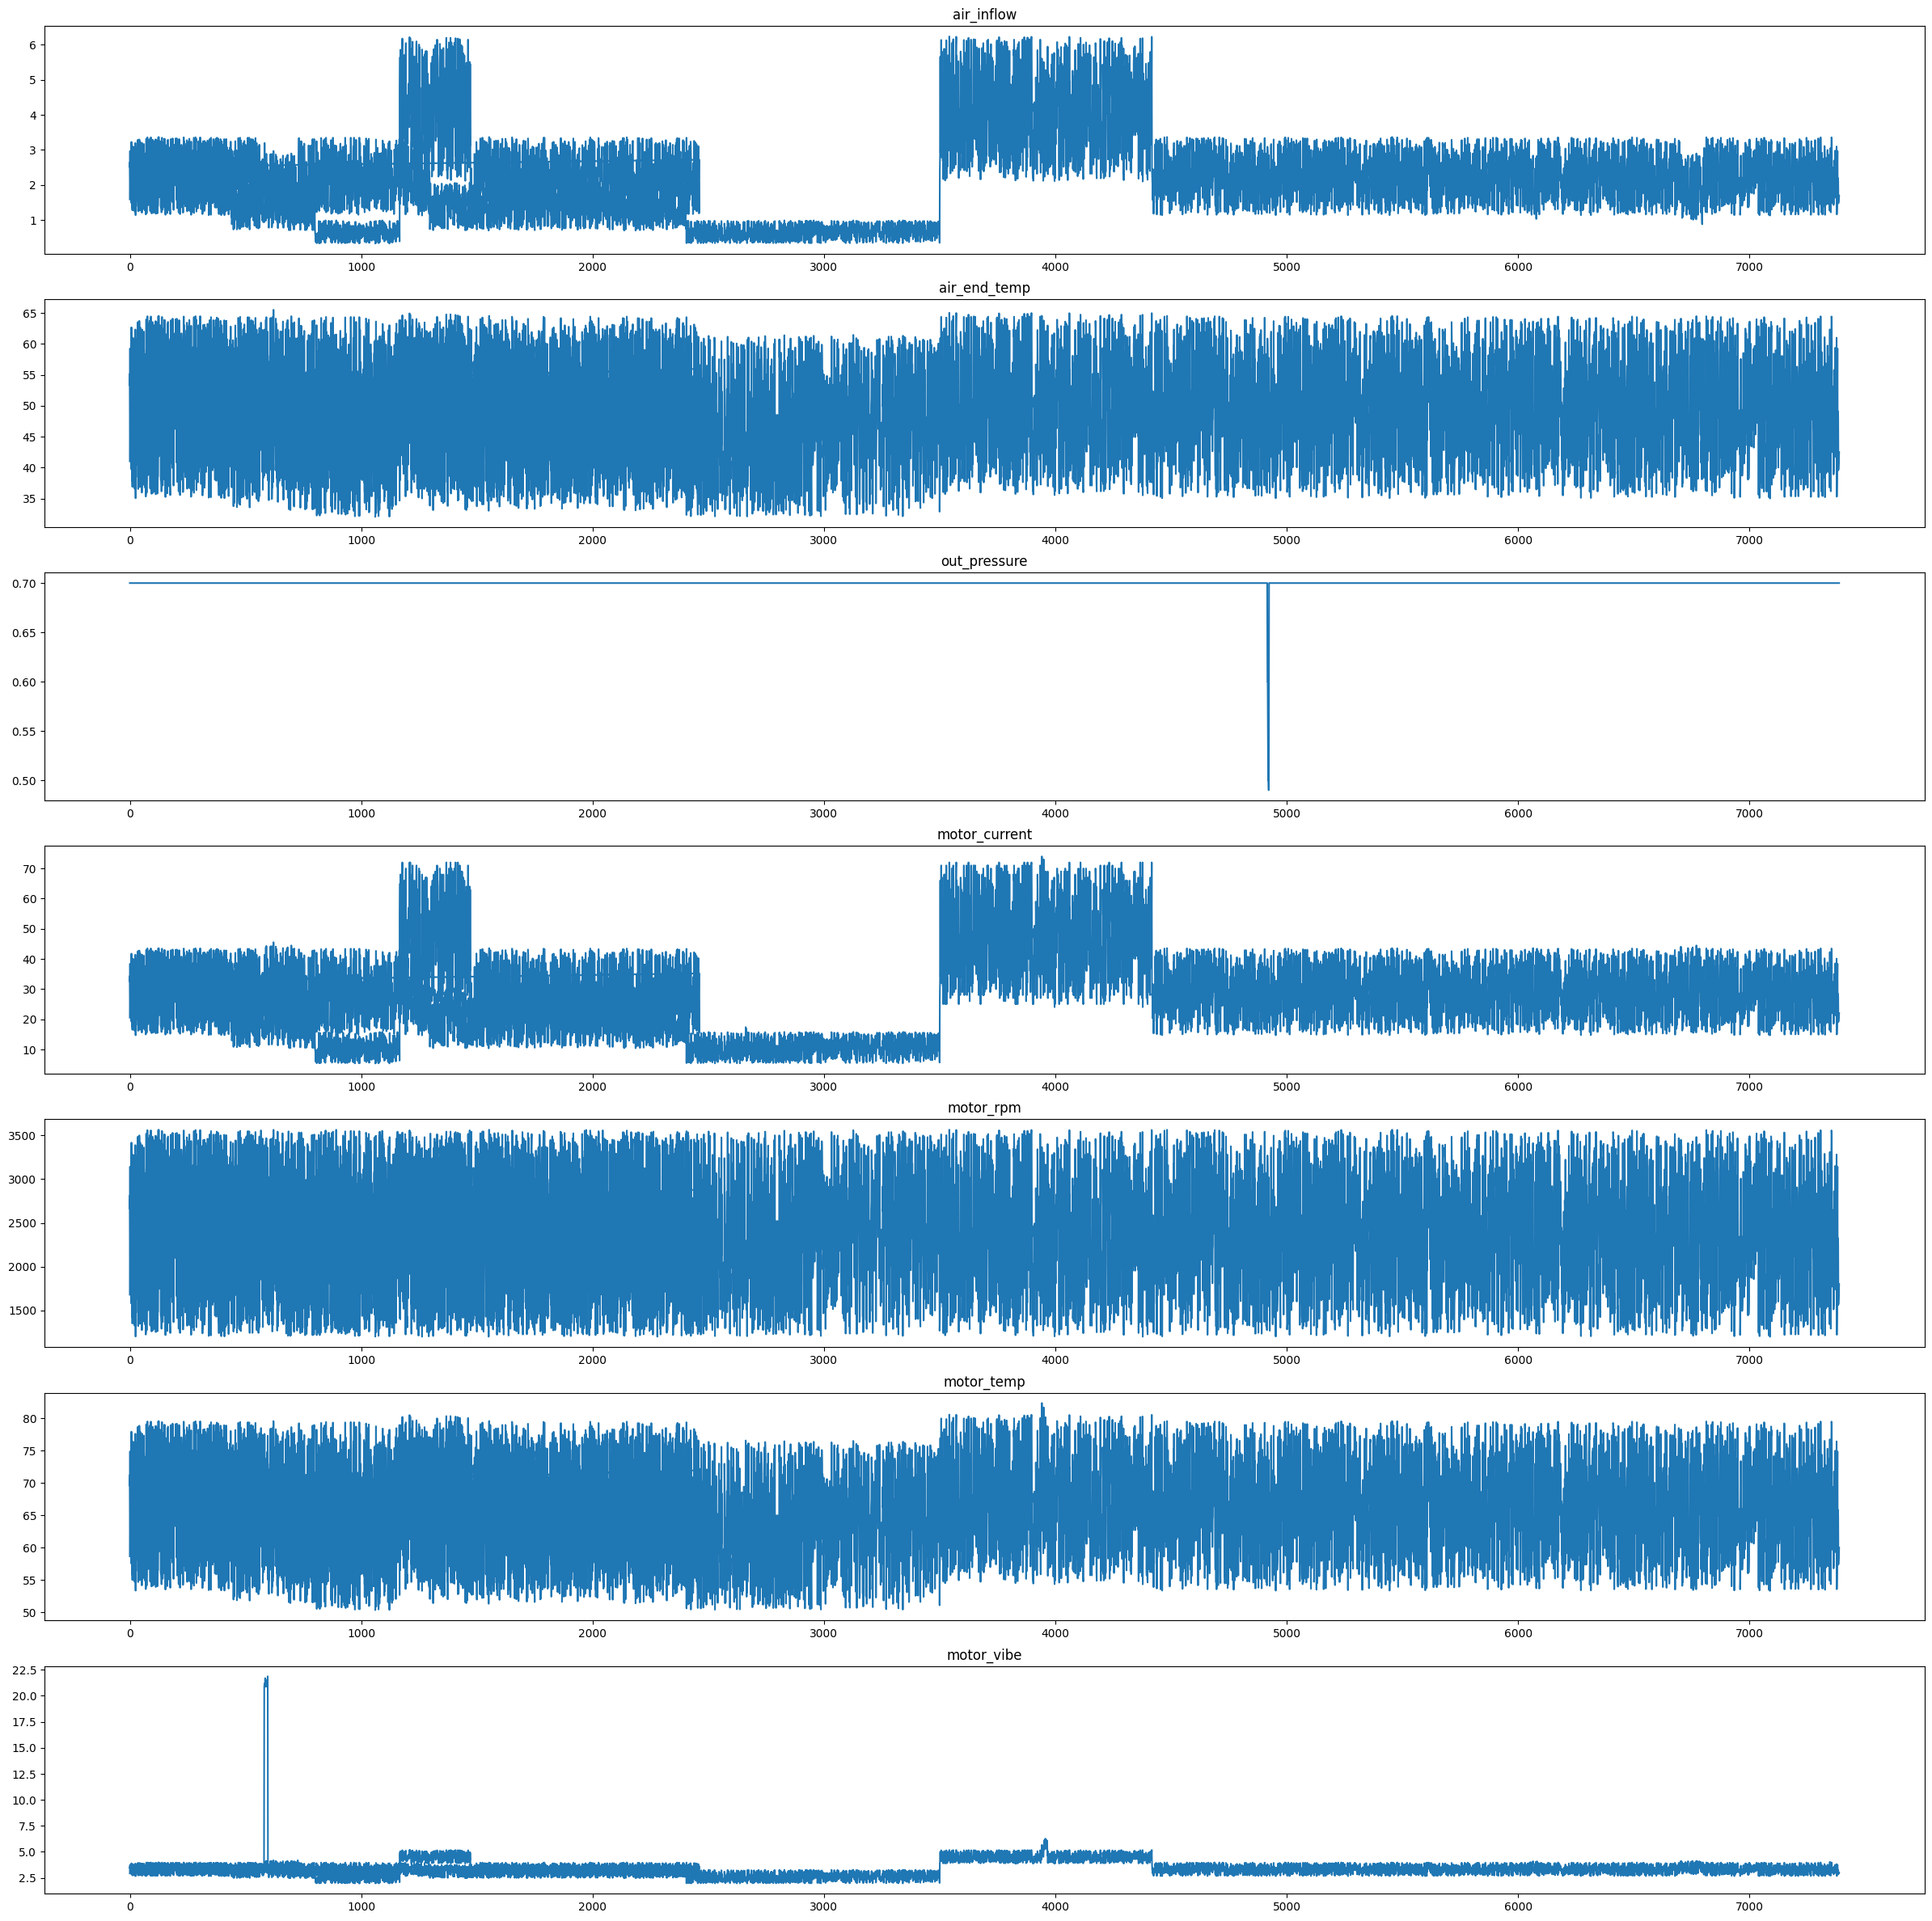

In [ ]:
col_li = [x for x in df.columns]

fig, axs = plt.subplots(nrows=7, ncols=1, figsize=(30,30), squeeze=False)
for i in range(7):
  axs[i][0].plot(df[col_li[i]])
  axs[i][0].set_title(str(col_li[i]))
  # lo,hi = plt.ylim()
  # axs[i][0].plot([len(train),len(train)],[lo+np.spacing(1),hi-np.spacing(1)],'k:')
plt.show


In [ ]:
# 스케일링 - 안하면 효과 낮음, 연속형 변수만 클러스터링 가능
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)
scaled_df = pd.DataFrame(df_scaled) # 변수 표준화됨
scaled_df.columns = df.columns
scaled_df

,air_inflow,air_end_temp,out_pressure,motor_current,motor_rpm,motor_temp,motor_vibe
0,-0.442693,-0.923779,0.025719,-0.518231,-1.008446,-0.915632,-0.457660
1,0.733147,1.178559,0.025719,0.822721,1.117478,1.178598,0.390653
2,-0.170034,-0.430397,0.025719,-0.203066,-0.509683,-0.424313,-0.261100
3,0.221912,0.264249,0.025719,0.239666,0.192658,0.266886,0.018223
4,-0.178555,-0.439598,0.025719,-0.209069,-0.518407,-0.433340,-0.261100
...,...,...,...,...,...,...,...
9847,0.008898,-0.109526,0.025719,0.001041,-0.185414,-0.104504,-0.126611
9848,-0.536419,-1.081340,0.025719,-0.618784,-1.168399,-1.074246,-0.519732
9849,-0.468255,-0.968632,0.025719,-0.546746,-1.053524,-0.960766,-0.468005
9850,-0.442693,-0.924930,0.025719,-0.518982,-1.009900,-0.916921,-0.457660


/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: F

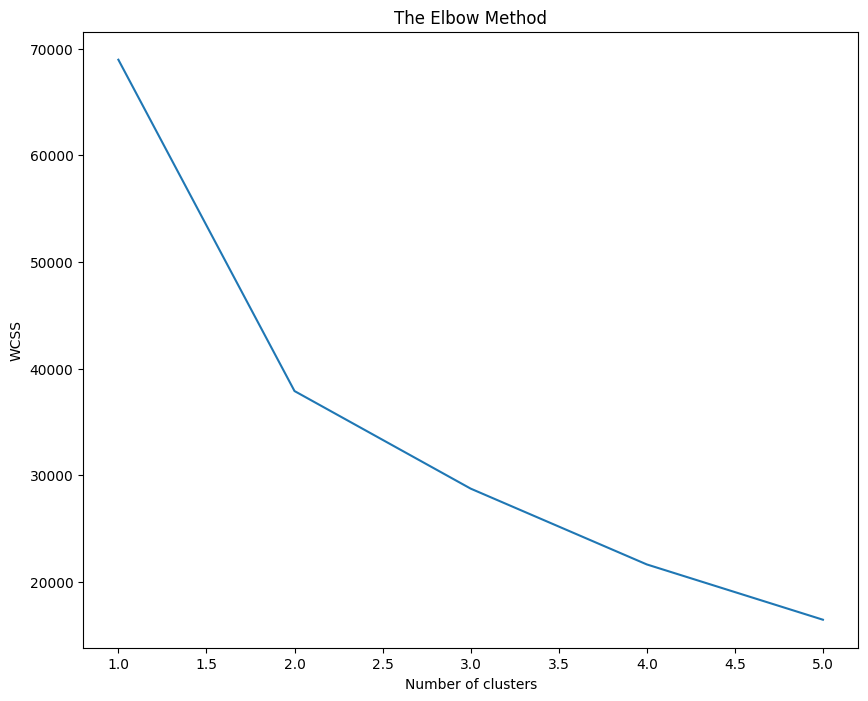

In [ ]:
plt.figure(figsize=(10, 8))
wcss = []
for i in range(1, 6):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(scaled_df)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 6), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show() # 최종 그룹 k = 2 로 결정

In [ ]:
# scaled된 데이터를 넣어 클러스터링
kmeans = KMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit(scaled_df)

#클러스터링 변수인 clusters 값을 원본 데이터에 넣기 
df['cluster'] = clusters.labels_
df

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,air_inflow,air_end_temp,out_pressure,motor_current,motor_rpm,motor_temp,motor_vibe,cluster
0,1.59,41.00,0.7,20.53,1680.0,58.67,2.93,0
1,2.97,59.28,0.7,38.40,3142.0,74.91,3.75,1
2,1.91,45.29,0.7,24.73,2023.0,62.48,3.12,0
3,2.37,51.33,0.7,30.63,2506.0,67.84,3.39,1
4,1.90,45.21,0.7,24.65,2017.0,62.41,3.12,0
...,...,...,...,...,...,...,...,...
7384,2.12,48.08,0.7,27.45,2246.0,64.96,3.25,0
7385,1.48,39.63,0.7,19.19,1570.0,57.44,2.87,0
7386,1.56,40.61,0.7,20.15,1649.0,58.32,2.92,0
7387,1.59,40.99,0.7,20.52,1679.0,58.66,2.93,0


In [ ]:
#cluster를 기준으로 데이터 개수 세기
df.groupby('cluster').count()

,air_inflow,air_end_temp,out_pressure,motor_current,motor_rpm,motor_temp,motor_vibe
cluster,,,,,,,
0,5267,5267,5267,5267,5267,5267,5267
1,4585,4585,4585,4585,4585,4585,4585


In [ ]:
train = df.iloc[:len(train),:]
test = df.iloc[len(train):,:]

In [ ]:
train.groupby('cluster').count()

,air_inflow,air_end_temp,out_pressure,motor_current,motor_rpm,motor_temp,motor_vibe
cluster,,,,,,,
0,1317,1317,1317,1317,1317,1317,1317
1,1146,1146,1146,1146,1146,1146,1146


In [ ]:
test.groupby('cluster').count()

,air_inflow,air_end_temp,out_pressure,motor_current,motor_rpm,motor_temp,motor_vibe
cluster,,,,,,,
0,3950,3950,3950,3950,3950,3950,3950
1,3439,3439,3439,3439,3439,3439,3439


# OneClassSVM

In [ ]:
submission

,type,label
0,0,-1
1,0,-1
2,0,-1
3,0,-1
4,0,-1
...,...,...
7384,7,-1
7385,7,-1
7386,7,-1
7387,7,-1


In [ ]:
type_dict={}
for i in range(8):
  type_dict[i] = train[train['type'] == i].iloc[:,:-1]

In [ ]:
type_dict_test={}
for i in range(8):
  type_dict_test[i] = test[test['type'] == i].iloc[:,:-1]

In [ ]:
type_dict.keys() # 타입별 딕셔너리

dict_keys([0, 1, 2, 3, 4, 5, 6, 7])

In [ ]:
X_tr = type_dict[0] # 데이터 로드
X_te = type_dict_test[0]

In [ ]:
# kernel : poly - 다항, linear - 선형, rbf - 방사형, sigmoid - 0,1사이 곡선
# nu : 오차 벡터 영향력 (error vector scale)
# gamma : kernel radius

# clf = OneClassSVM(nu=0.1, kernel="rbf", gamma=0.1) # 하이퍼파라미터 튜닝 -> nu, gamma 만. gamma는 선택사항.
clf = OneClassSVM(nu=0.5, kernel="rbf")

In [ ]:
clf.fit(X_tr) # 모델 학습

OneClassSVM(gamma=0.1, nu=0.1)

In [ ]:
pred = clf.predict(X_te) # 모델 사용
scores = clf.score_samples(X_te) # boundary 점수

In [ ]:
X_te['anomaly'] = pred
X_te['scores'] = scores

In [ ]:
X_te[X_te['anomaly'] == 1] # 정상
X_te[X_te['anomaly'] == -1] # 비정상

,air_inflow,air_end_temp,out_pressure,motor_current,motor_rpm,motor_temp,motor_vibe,anomaly,scores
0,2.51,53.28,0.7,32.54,2662.0,69.58,3.48,1,0.312650
1,2.66,55.24,0.7,34.45,2819.0,71.32,3.57,1,0.327805
2,1.72,42.74,0.7,22.23,1819.0,60.21,3.01,1,0.313061
3,2.20,49.15,0.7,28.50,2332.0,65.91,3.30,1,0.312740
4,2.06,47.28,0.7,26.67,2182.0,64.24,3.21,1,0.312981
...,...,...,...,...,...,...,...,...,...
1288,1.44,39.11,0.7,18.69,1529.0,56.99,2.85,1,0.319658
1289,2.34,50.95,0.7,30.26,2476.0,67.51,3.38,1,0.312677
1290,1.35,37.90,0.7,17.50,1432.0,55.91,2.80,1,0.313367
1292,3.16,61.79,0.7,40.86,3343.0,77.14,3.86,1,0.313631


# IsolationForest

In [ ]:
type_dict={}
for i in range(8):
  type_dict[i] = train[train['type'] == i].iloc[:,:-1]

In [ ]:
type_dict_test={}
for i in range(8):
  type_dict_test[i] = test[test['type'] == i].iloc[:,:-1]

In [ ]:
X_tr = type_dict[0] # 데이터 로드
X_te = type_dict_test[0]

In [ ]:
model=IsolationForest(n_estimators=100, max_samples='auto', n_jobs=-1, # 모델 구축
                      max_features=2, contamination=0.01)
model.fit(X_tr) # 모델 학습

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


IsolationForest(contamination=0.01, max_features=2, n_jobs=-1)

In [ ]:
score = model.decision_function(X_te) # 아웃바운더리 점수
anomaly = model.predict(X_te) # 모델 사용

In [ ]:
X_te['scores']= score
X_te['anomaly']= anomaly

In [ ]:
X_te[X_te['anomaly'] == 1] # 정상
X_te[X_te['anomaly'] == -1] # 비정상

,air_inflow,air_end_temp,out_pressure,motor_current,motor_rpm,motor_temp,motor_vibe,scores,anomaly
25,1.14,35.04,0.7,14.70,1203.0,53.37,2.67,-0.032359,-1
265,1.15,35.28,0.7,14.94,1222.0,53.58,2.68,-0.000506,-1
409,1.14,35.05,0.7,14.72,1204.0,53.38,2.67,-0.032359,-1
988,1.15,35.16,0.7,14.83,1213.0,53.48,2.67,-0.017890,-1
1248,1.15,35.16,0.7,14.83,1213.0,53.48,2.67,-0.017890,-1
1263,1.13,35.00,0.7,14.67,1200.0,53.33,2.67,-0.032359,-1


# ECOD

In [ ]:
# ready for data compute

type_dict={}
for i in range(8):
  type_dict[i] = train[train['type'] == i].iloc[:,:-1]

type_dict_test={}
for i in range(8):
  type_dict_test[i] = test[test['type'] == i].iloc[:,:-1]

# Model train
df = pd.DataFrame()

for i in range(8): # type roop
  X_tr = type_dict[i]
  X_te = type_dict_test[i]

  # Model Define
  model = ECOD() # default parameter
  
  model.fit(X_tr) # Train model with trainset
  pred = model.predict(X_te) # Classify Outboundary
  X_te['anomaly'] = pred # 0 is inboundary, 1 is outboundary -> don't need to change to submission form
  X_te['type'] = i # compute type
  df = pd.concat([df,X_te], axis=0) # concat full test data

submission['label'] = df['anomaly']

/usr/local/lib/python3.9/dist-packages/pyod/models/ecod.py:25: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return np.nan_to_num(skew_sp(X, axis=axis))
/usr/local/lib/python3.9/dist-packages/pyod/models/ecod.py:25: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return np.nan_to_num(skew_sp(X, axis=axis))
/usr/local/lib/python3.9/dist-packages/pyod/models/ecod.py:25: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return np.nan_to_num(skew_sp(X, axis=axis))
/usr/local/lib/python3.9/dist-packages/pyod/models/ecod.py:25: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. T

In [ ]:
submission

,type,label
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
7384,7,0
7385,7,0
7386,7,0
7387,7,0


# Ensemble

In [ ]:
# initialized a group of outlier detectors for acceleration
detector_list = [LOF(n_neighbors=15), LOF(n_neighbors=20), # public score : 0.53
                 LOF(n_neighbors=25), LOF(n_neighbors=35),
                 COPOD(), IForest(n_estimators=100),
                 IForest(n_estimators=200)]

In [ ]:
# ready for data compute
type_dict={}
for i in range(8):
  type_dict[i] = train[train['type'] == i].iloc[:,:-1]

type_dict_test={}
for i in range(8):
  type_dict_test[i] = test[test['type'] == i].iloc[:,:-1]

# Model train
df = pd.DataFrame()

for i in range(8): # type roop
  X_tr = type_dict[i]
  X_te = type_dict_test[i]

  # Model Define
  # decide the number of parallel process, and the combination method
  # then clf can be used as any outlier detection model
  model = SUOD(base_estimators=detector_list, n_jobs=2, combination='average',
           verbose=False) # default parameter
  
  model.fit(X_tr) # Train model with trainset
  pred = model.predict(X_te) # Classify Outboundary
  X_te['anomaly'] = pred # 0 is inboundary, 1 is outboundary -> don't need to change to submission form
  X_te['type'] = i # compute type
  df = pd.concat([df,X_te], axis=0) # concat full test data

submission['label'] = df['anomaly']

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    3.5s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    3.5s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    2.1s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    2.1s finished


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    2.4s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    2.4s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    1.3s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    1.3s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    3.8s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    3.8s finished


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    5.6s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    5.6s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    1.9s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    1.9s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    2.1s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    2.1s finished


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    7.0s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    7.0s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    1.5s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    2.8s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    2.8s finished


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    4.0s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    4.0s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    2.4s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    2.4s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    2.0s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    2.0s finished


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    2.3s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    2.3s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    1.3s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    1.3s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    2.0s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    2.0s finished


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    3.4s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    3.4s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    2.1s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    2.1s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    2.0s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    2.0s finished


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    2.3s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    2.3s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    1.2s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    2.0s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    2.0s finished


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    3.1s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    3.1s finished


In [ ]:
submission

,type,label
0,0,1
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
7384,7,0
7385,7,0
7386,7,0
7387,7,0


In [ ]:
# submission.to_csv("/content/drive/MyDrive/PythonProjects/submission/ensemble_1.csv")

# AutoEncoder

In [ ]:
# ready for data compute

type_dict={}
for i in range(8):
  type_dict[i] = train[train['type'] == i].iloc[:,:-1]

type_dict_test={}
for i in range(8):
  type_dict_test[i] = test[test['type'] == i].iloc[:,:-1]

# Model train
df = pd.DataFrame()

for i in range(8): # type roop
  X_tr = type_dict[i]
  X_te = type_dict_test[i]

  # Model Define
  model = AutoEncoder(epochs=10) # default parameter
  
  model.fit(X_tr.values) # Train model with trainset
  pred = model.predict(X_te.values) # Classify Outboundary
  X_te['anomaly'] = pred # 0 is inboundary, 1 is outboundary -> don't need to change to submission form
  X_te['type'] = i # compute type
  df = pd.concat([df,X_te], axis=0) # concat full test data

submission['label'] = df['anomaly']

InnerAutoencoder(
  (activation): ReLU()
  (encoder): Sequential(
    (linear0): Linear(in_features=7, out_features=64, bias=True)
    (batch_norm0): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=32, bias=True)
    (batch_norm1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (linear0): Linear(in_features=32, out_features=64, bias=True)
    (batch_norm0): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=64, out_features=7, bias=True)
    (relu1): ReLU()
  )
)


/usr/local/lib/python3.9/dist-packages/pyod/models/auto_encoder_torch.py:40: RuntimeWarning: invalid value encountered in true_divide
  sample = (sample - self.mean) / self.std


epoch 0: training loss nan 
epoch 1: training loss nan 
epoch 2: training loss nan 
epoch 3: training loss nan 
epoch 4: training loss nan 
epoch 5: training loss nan 
epoch 6: training loss nan 
epoch 7: training loss nan 
epoch 8: training loss nan 
epoch 9: training loss nan 


TypeError: ignored

# 요약 

In [ ]:
# ready for data compute

type_dict={}
for i in range(8):
  type_dict[i] = train[train['type'] == i].iloc[:,:-1]

type_dict_test={}
for i in range(8):
  type_dict_test[i] = test[test['type'] == i].iloc[:,:-1]

# Model train
df = pd.DataFrame()

for i in range(8): # type roop
  X_tr = type_dict[i]
  X_te = type_dict_test[i]

  # Model Define
  svm = OneClassSVM(nu=0.5, kernel="rbf") # default parameter
  
  svm.fit(X_tr) # Train model with trainset
  pred = svm.predict(X_te) # Classify Outboundary
  X_te['anomaly'] = pred # -1 is outboundary, 1 is inboundary
  X_te['type'] = i # compute type
  df = pd.concat([df,X_te], axis=0) # concat full test data

# change -1 to 1, 1 to 0 (for submission)
for j in range(len(df)):
  if df['anomaly'][j] == 1: # normal data
    df['anomaly'][j] = 0
  else: # abnormal data
    df['anomaly'][j] = 1

submission['label'] = df['anomaly']

<ipython-input-23-0d79fb2ff226>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['anomaly'][j] = 0
<ipython-input-23-0d79fb2ff226>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['anomaly'][j] = 1


In [ ]:
submission

,type,label
0,0,0
1,0,0
2,0,1
3,0,0
4,0,0
...,...,...
7384,7,0
7385,7,1
7386,7,1
7387,7,0
